<a href="https://colab.research.google.com/github/Mahnazshamissa/Asigmo-Hackathon-/blob/main/team2_full_model_v0_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

The Hahackaton aims at classifying text as humorous.
The dataset is a set of short texts that have been labeled by a group of heterogenous people (age, sex, race) under 4 features: 
* 1a: is it humorous? (binary label) 
* 1b: humour grading (0 to 5; 0 is not humorous)
* 1c: controversy (binary label): when the variance in the humour grading is higher than the average
* 2a: offensiveness grading (0 to 5; 0 is not offensive)

******

In general, we approached the problem by extracting simple features: text length (in words), punctuation frequency, and most important, the text word content, with the use of count_vectorizer. Before this feature extraction, we previously pre-processed the data: tokenization of words, get rid of punctuation and non-word symbols, lower case, among others.

For task 1a, we applied logistic regression, multinomial naive bayes, and XGBoost. Additionally, we use a FastText to classify according to word context embedding. 

We observe that we reach a ceiling of 86% of accuracy. In order to try to improve the score, and under the assumption that each model bases its execution on different aspects of the data -specially FastText -, we combine all the individual models to build an ensemble model (stacking classifier). This led to an improve over the baseline model of 1%.

For 1b, we applied the same data preprocessing strategy followed by Elastic Net regression.

For 1c, we applied the same data preprocessing strategy followed by  Multinomial Naive Bayes,

For 2a, we applied the same data preprocessing strategy followed by XGBoost.

This is the summary of our scores:


| Attribute         | *Accuracy* | *f1-score* | *RMSE* |
| :---------------- | ---------: | ---------: | -----: |
| is_humour         | 87%        | 90%        | -      |
| humor_rating      | ---        | ---        | 0.551  |
| humor_controversy | 55%        | 55%        | -      |
| offense_rating    | ---        | ---        | 0.812  |



# settings

## install packages

In [ ]:
## download fasttext and nltk
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..
!cd ./fastText && pip install .
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

!pip install shap

fatal: destination path 'fastText' already exists and is not an empty directory.
/content/fastText
make: Nothing to be done for 'opt'.
/content
Processing /content/fastText
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3030909 sha256=7545ef675bfdd6f435a4d739a6881e5888d259d36577919e874657892dc2c741
  Stored in directory: /tmp/pip-ephem-wheel-cache-5vkkpjvr/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext
  Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##import packages

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingClassifier
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import fasttext

import shap
import time

#from matplotlib import pyplot as plt
#from sklearn.model_selection import RepeatedKFold
import warnings # Ignore warning
import pickle

# data preparation

## import the data - split train/test - class balance

In [ ]:
df = pd.read_csv('./train.csv').drop(columns = 'id')
df.head()

,text,is_humor,humor_rating,humor_controversy,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


## preprocessing functions

In [ ]:
def stemmer(text, stemmer):
    return(' '.join([stemmer.stem(w) for w in word_tokenize(text)]))

def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemm_words = []
    for w in word_tokenize(text):
      w = lemmatizer.lemmatize(w,pos='n')
      w = lemmatizer.lemmatize(w,pos='v')
      lemm_words.append(w)
    lemmatized = " ".join(lemm_words)
    return lemmatized

def count_words(input):
    """ Returns number of occurences of characters specified in char """     
    return len(input.split())

def remove_punctuation(s_input, include_char = None):
    """ Returns input string without punctuation """
    import string as String
    punct = String.punctuation
    
    if not include_char is None:
        index = String.punctuation.index(include_char)
        punct = String.punctuation[:index] + String.punctuation[(index + 1):]
        
    punct += '\n'
        
    translator = str.maketrans(punct, ' '*len(punct))
    
    return s_input.translate(translator)

def remove_stopwords(text, use_stopwords = None, df = True, exclude_number = True):
    """ Returns input string removing stopwords from it. """
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    if use_stopwords is None:
        use_stopwords = set(stopwords.words("english"))
        
    if df:
        new_text = word_tokenize(text)
        if exclude_number:
            new_text = [word for word in new_text if not word.isnumeric()]
        new_text = " ".join([word for word in new_text if word not in use_stopwords])
    else:
        new_text = ""
        for word in text:
            if word not in use_stopwords:
                new_text += word + " "

    return new_text

def sep_upper(text):
    """ Take a text as input and insert space before every uppercase letter. """
    
    new_text = ""
    for letter in text:
        if letter.isupper():
            new_text += " " + letter
        else:
            new_text += letter
    
    return new_text

def remove_space(text):
    return(re.sub(' +',' ',text))

In [ ]:
def pre_proc(text_col):
    text_col = text_col.apply(remove_punctuation) # removes String.punctuation characters
    #text_col = text_col.apply(remove_stopwords)   # removes english stopwords 
    text_col = text_col.str.replace('[^\w\s]','').str.strip() # and removes whitespaces   
    text_col = text_col.apply(sep_upper) # adds space before an uppercase
    text_col = text_col.str.lower() # lowercase
    text_col = text_col.apply(lemmatize_text)     
    return text_col

In [ ]:
def punctuations(s_input):
    import string as String
    puncts = [el for el in s_input if el in String.punctuation]   
    return ''.join(puncts)

def text_len(s_input):
    ll = s_input.split(' ')
    return len(ll)

def word_len(s_input):
    return len(s_input)

def quotes(s_input):
    return s_input.count('"')

def dots(s_input):
    return s_input.count('.')

def exclMk(s_input):
    return s_input.count('!')

def questMk(s_input):
    return s_input.count('?')

def extraFeats(df):
  df['punct_'] = df.text_.apply(punctuations) 
  df['punct_len'] = df.punct_.apply(word_len) / df['qtd_words']
  df['word_len'] = df.text_.apply(word_len) / df['qtd_words']
  df['quotes_'] = df.text_.apply(quotes) / df['qtd_words']
  df['dots_'] = df.text_.apply(dots) / df['qtd_words']
  df['exclMk_'] = df.text_.apply(exclMk) / df['qtd_words']
  df['questMk_'] = df.text_.apply(questMk) / df['qtd_words']
  return df

In [ ]:
vectorizer = CountVectorizer(max_features=4_000)

def fullPreProcess(dfx,fit=True):
  global vectorizer
  dfx['processed_text'] = pre_proc(dfx.text_)
  dfx['qtd_words'] = dfx.processed_text.apply(count_words)
  dfx = extraFeats(dfx)
  if fit:
    dfx_trans = pd.DataFrame(vectorizer.fit_transform(dfx.processed_text).toarray()
                             , columns = vectorizer.get_feature_names()
                             , index = dfx.index)
  else:
    dfx_trans = pd.DataFrame(vectorizer.transform(dfx.processed_text).toarray()
                             , columns = vectorizer.get_feature_names()
                             , index = dfx.index)
  dfx_trans = pd.concat([dfx_trans,dfx],axis=1)
  dfx_trans['qtd_words'] = dfx.processed_text.apply(count_words)
  return dfx_trans


In [ ]:
# convenience class to wrap FastText to comply with skklearn estimator interface (fit,predict,predict_proba methods)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances

class AsigmoFastText(BaseEstimator,ClassifierMixin):
  def __init__(self,input='./trainset.txt',lr=1.0, epoch=5,wordNgrams=1,ws=5,verbose=2):
    self.input = input
    self.lr = lr 
    self.epoch = epoch
    self.wordNgrams = wordNgrams
    self.ws = ws
    self.verbose = verbose  
  
  def get_params(self,deep=True):
    return {'input':self.input,
            'lr':self.lr,
            'epoch':self.epoch,
            'wordNgrams':self.wordNgrams,
            'ws':self.ws,
            'verbose':self.verbose}
  
  def set_params(self,**parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

  def toFastTextFormat(self,series_x,series_y,input):
    """ 
    transforms the data to a text file following 
    the format required by L{fasttext.train_supervised}, that is, a text file
    where each line is a sentence preceded by the labels with format: 
    C{__label__<label1> <sentence>}
    This function only allows one label


    @param series_x : a pandas series of str, named "text", with the sentences
    @type series_x: pandas.Series
    @param series_y : a pandas series with the labels for "text"
    @type series_y: pandas.Series
    @param input: the path for the text file to save
    @type input: str

    @return: None 
    """
    xx = pd.DataFrame(series_x)
    xx['label'] = series_y
    xx['ft_label'] = '__label__'+xx['label'].astype(str)
    xx['ft_sent'] = xx['ft_label'] + ' ' + xx['processed_text']
    ft_text = xx.ft_sent.str.cat(sep='\n')

    with open(input,"w") as fl:
      fl.write(ft_text)

  def fit(self,x_train,y_train):
    # x_train, y_train = check_X_y(x_train, y_train, dtype=None)
    # x_train = check_array(x_train, dtype = None)
    self.X_ = x_train.copy()
    self.y_ = y_train.copy()
    self.classes_ = unique_labels(self.y_)
    self.toFastTextFormat(self.X_, self.y_, self.input)
    self.model = fasttext.train_supervised(input=self.input,lr=self.lr, epoch=self.epoch,wordNgrams=self.wordNgrams,ws=self.ws,verbose=self.verbose)
    self.model.save_model('./model.bin') ###
    return self

  def predict_proba(self,x_test):
    check_is_fitted(self, ['X_', 'y_'])   
    # x_test = check_array(x_test, dtype = None)# Input validation

    dff = x_test['processed_text']  
    def fastTextPredProba(df):      
      lbl = self.model.predict(df)[0][0][-1] #get the label assigned "__label__<#>" -> <#>
      proba_raw = float(self.model.predict(df)[1][0]) #get the probability score (it is an array)
      proba_raw = 1.0 if proba_raw > 1 else proba_raw
      proba_raw = 0.0 if proba_raw < 0 else proba_raw
      if int(lbl) == 1:
        return pd.Series([1-proba_raw,proba_raw])
      else:
        return pd.Series([proba_raw,1-proba_raw])   
    return dff.apply(fastTextPredProba).to_numpy()

  def predict(self,x_test): 
    check_is_fitted(self, ['X_', 'y_'])   
    # x_test = check_array(x_test, dtype = None) # Input validation

    dff = x_test['processed_text']  
    def fastTextPred(df):      
      lbl = self.model.predict(df)[0][0][-1] #get the label assigned "__label__<#>" -> <#>
      return int(lbl)
    return dff.apply(fastTextPred)

# 1a => is_humor

In [ ]:
X = df[['text']] #4932 Do not reset the index!
X.columns = ['text_']
y = df[['is_humor']] #4932

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
"X_train and y_train shape: {0}, {1}, X_test and y_test shape {2}, {3}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



'X_train and y_train shape: (6400, 1), (6400, 1), X_test and y_test shape (1600, 1), (1600, 1)'

In [ ]:
total = len(y_train)
print('% of positives is ', round(y_train.sum()/total, 2)) #'% of positives is {:.2f}'.format(y_train.sum()/total)
print('% of negatives is ', round((total - y_train.sum())/total, 2)) #'% of negatives is {:.2f}'.format((total - y_train.sum())/total)

class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels,y= y_train['is_humor'])
class_weights_dict = dict(zip(class_labels, class_weights))
print('class weights: ',class_weights_dict)

% of positives is  is_humor    0.61
dtype: float64
% of negatives is  is_humor    0.39
dtype: float64
class weights:  {0: 1.29764801297648, 1: 0.813421453990849}


## preprocessing

In [ ]:
X_train_trans = fullPreProcess(X_train,fit=True)
X_test_trans = fullPreProcess(X_test,fit=False)

In [ ]:
get_numerical_data = FunctionTransformer(lambda x: x[x.columns.difference(['text_','processed_text','punct_'],sort=False)], validate=False)

## independent models (pre-ensemble)

### Multinomial NB model

In [ ]:
trans_mnb = Pipeline([
    ('num_data',get_numerical_data),
    ('clf',MultinomialNB())])

trans_mnb.fit(X_train_trans, y_train.is_humor)

# quick check
trans_mnb.score(X_test_trans,y_test.is_humor)

0.85125

### Logistic Regression

In [ ]:
trans_logit = Pipeline([
    ('num_data',get_numerical_data),
    ('clf',LogisticRegression(C=100,penalty='l2',max_iter=10000,tol=0.001,class_weight=class_weights,random_state=42))])

trans_logit.fit(X_train_trans, y_train.is_humor)

# quick check
trans_logit.score(X_test_trans,y_test.is_humor)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.8075

### XGBoost model

In [ ]:
trans_xgb = Pipeline([
    ('num_data',get_numerical_data),
    ('clf',xgb.XGBClassifier(max_depth=4))])

trans_xgb.fit(X_train_trans, y_train.is_humor)

# quick check
trans_xgb.score(X_test_trans,y_test.is_humor)

0.824375

### FastText - word context vector embedding

In [ ]:
ft = AsigmoFastText(input='./train.txt',lr=0.3,epoch=50,wordNgrams=3,ws=10)
ft.fit(X_train_trans,y_train.is_humor)

# quick test
y_pred = ft.predict(X_test_trans)
accuracy_score(y_test.is_humor,y_pred)

0.865

### visualization of model performance

In [ ]:
modelEvaluation = y_test.copy()
modelEvaluation['mnb_proba'] = trans_mnb.predict_proba(X_test_trans)[:,1]
#modelEvaluation['logit_proba'] = trans_logit.predict_proba(X_test_trans)[:,1]
#modelEvaluation['xgb_proba'] = trans_xgb.predict_proba(X_test_trans)[:,1]
modelEvaluation['fastText_proba'] = ft.predict_proba(X_test_trans)[:,1]

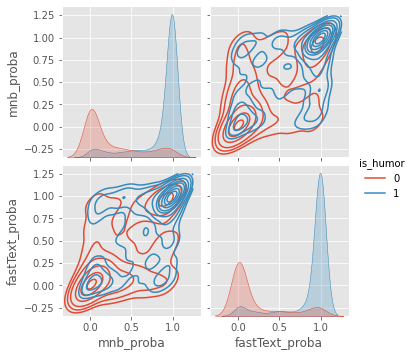

In [ ]:
sns.pairplot(data=modelEvaluation,hue='is_humor',kind='kde',diag_kind='kde')

## ensemble model

In [ ]:
trans_mnb = Pipeline([
    ('num_data',get_numerical_data),
    ('clf',MultinomialNB())])

trans_logit = Pipeline([
    ('num_data',get_numerical_data),
    ('clf',LogisticRegression(C=100,penalty='l2',max_iter=10000,tol=0.001,class_weight=class_weights,random_state=42))])

trans_xgb = Pipeline([
    ('num_data',get_numerical_data),
    ('clf',xgb.XGBClassifier(max_depth=4))])

estimators =[#('lr',trans_logit),
             ('mnb',trans_mnb),
             #('xgb',trans_xgb),
             ('fasttext',AsigmoFastText(input='./train_text.txt',lr=0.3,epoch=50,wordNgrams=3,ws=10))]

stackClassif = StackingClassifier(estimators=estimators,
                                  final_estimator=LogisticRegression(random_state=42))

In [ ]:
stackClassif.fit(X_train_trans,y_train.is_humor)


StackingClassifier(cv=None,
                   estimators=[('mnb',
                                Pipeline(memory=None,
                                         steps=[('num_data',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x7fb5bb78fd90>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     validate=False)),
                                                ('clf',
                                                 MultinomialNB(alpha=1.0,
                                                   

In [ ]:
y_pred = stackClassif.predict(X_test_trans)
acc = accuracy_score(y_test.is_humor,y_pred)
f1 = f1_score(y_test.is_humor,y_pred)
print("ensemble model: \n\t {}% accuracy,\n\t {}% f1 score.\n\n confusion matrix:".format(100*acc,100*f1))
confusion_matrix(y_test.is_humor,y_pred)

ensemble model: 
	 87.5625% accuracy,
	 90.08470353761832% f1 score.

 confusion matrix:


array([[497, 105],
       [ 94, 904]])

### visualization

In [ ]:
modelEvaluation['ensemble_proba'] = stackClassif.predict_proba(X_test_trans)[:,1]

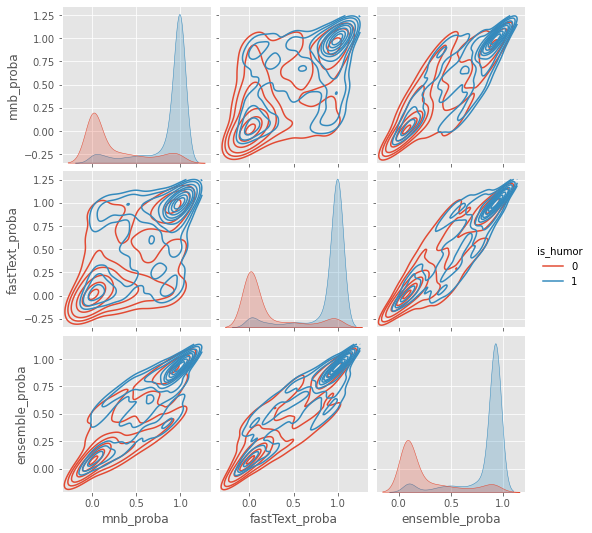

In [ ]:
sns.pairplot(data=modelEvaluation,hue='is_humor',kind='kde',diag_kind='kde')

### transparency visualization (shap)

In [ ]:
X_train_trans

,00,000,03,10,100,1000,11,12,13,14,15,150,16,17,18,180,19,1940,1984,1st,20,200,200th,2012,2013,2014,2015,2017,2018,2019,2020,21,22,23,24,25,26,29,2nd,30,...,yes,yesterday,yet,yo,yoda,yodas,yoga,yoghurt,yogurt,yoko,york,you,young,younger,youngest,your,youre,yours,yourself,youth,youtube,yr,yum,yup,zero,zombie,zone,zoo,zookeeper,âï,text_,processed_text,qtd_words,punct_,punct_len,word_len,quotes_,dots_,exclMk_,questMk_
2283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Imagine working for millions of years on somet...,imagine work for million of year on something ...,39,.'-.,0.102564,5.282051,0.000000,0.051282,0.0,0.000000
2650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,What's the difference between a gay man and a ...,what s the difference between a gay man and a ...,21,'?'.,0.190476,4.904762,0.000000,0.047619,0.0,0.047619
1871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Have been inspired by your ""owe no man nothing...",have be inspire by your owe no man nothing but...,26,""""".,..",0.230769,5.230769,0.076923,0.115385,0.0,0.000000
259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"You can't count on pleasing everyone, so focus...",you can t count on please everyone so focus on...,16,"',",0.125000,5.187500,0.000000,0.000000,0.0,0.000000
6367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Keep posting videos of your children being bra...,keep post video of your child be brat it s gre...,27,.''.,0.148148,5.481481,0.000000,0.074074,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,What helps me with these things is using that ...,what help me with these thing be use that awar...,38,".,,",0.078947,5.184211,0.000000,0.026316,0.0,0.000000
772,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"A few months ago while in Israel, I met a man ...",a few month ago while in israel i meet a man n...,58,",.-@.'""."".://./",0.258621,4.344828,0.034483,0.086207,0.0,0.000000
5944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Since 2007, all of McDonald's delivery trucks ...",since 2007 all of mc donald s delivery truck i...,23,",'.",0.130435,5.043478,0.000000,0.043478,0.0,0.000000
5327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,What do you get when you play tug of war with ...,what do you get when you play tug of war with ...,15,?.,0.133333,4.333333,0.000000,0.066667,0.0,0.066667


In [ ]:
X_train_trans_num = X_train_trans[X_train_trans.columns.difference(['text_','processed_text','punct_'],sort=False)]
X_test_trans_num = X_test_trans[X_test_trans.columns.difference(['text_','processed_text','punct_'],sort=False)]

## not working!
explainer = shap.KernelExplainer(stackClassif.predict_proba, X_train_trans)
#shap_values = explainer.shap_values(X_test.iloc[0,:])
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

Provided model function fails when applied to the provided data set.


AttributeError: ignored

## saving the model

In [ ]:
with open('1a_vectorizer.pkl', 'wb') as file: 
    pickle.dump(vectorizer.vocabulary_, file) # countvectorizer
#with open('1a_mnb.pkl', 'wb') as file: 
#    pickle.dump(trans_mnb, file) # multinomialNB
#with open('1a_stackClassif.pkl', 'wb') as file: 
#    pickle.dump(stackClassif, file) # stackingClassifier
#with open('1a_fastTextModel.pkl', 'wb') as file:
#    pickle.dump(ft, file)


In [ ]:
del X, y, X_train, X_test, y_train, y_test, vectorizer, X_train_trans, X_test_trans

#1b => humor_rating

## data preparation

In [ ]:
X = df[df['is_humor']==1][['text']] # Do not reset the index!
y = df[df['is_humor']==1][['humor_rating']] #

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
"X_train and y_train shape: {0}, {1}, X_test and y_test shape {2}, {3}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'X_train and y_train shape: (3945, 1), (3945, 1), X_test and y_test shape (987, 1), (987, 1)'

In [ ]:
X_train.text = pre_proc(X_train.text)
X_test.text = pre_proc(X_test.text)

vectorizer = CountVectorizer() # ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=4

X_train_trans = pd.DataFrame(vectorizer.fit_transform(X_train.text).toarray()
                             , columns = vectorizer.get_feature_names()
                             , index = X_train.index)
X_train_trans['qtd_words'] = X_train.text.apply(count_words)

X_test_trans = pd.DataFrame(vectorizer.transform(X_test.text).toarray()
                            , columns = vectorizer.get_feature_names()
                            , index = X_test.index)
X_test_trans['qtd_words'] = X_test.text.apply(count_words)

## model

In [ ]:
reg = ElasticNet(l1_ratio = 0.0)
reg.fit(X_train_trans, y_train)

y_pred = reg.predict(X_test_trans)
mean_squared_error(y_test, y_pred, squared = False) # squared = F will return the RMSE

Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.7380346263329, tolerance: 0.12784338972370093


0.5508491704701347

## saving the model

In [ ]:
with open('1b_vectorizer.pkl', 'wb') as file: 
    pickle.dump(vectorizer.vocabulary_, file) # countvectorizer
with open('1b_reg.pkl', 'wb') as file: 
    pickle.dump(reg, file) # countvectorizer

In [ ]:
del X, y, X_train, X_test, y_train, y_test, vectorizer, X_train_trans, X_test_trans

# 1c => humor_controversy



## data preparation

In [ ]:
X = df[df['is_humor']==1][['text']] #4932 Do not reset the index!
y = df[df['is_humor']==1][['humor_controversy']] #4932

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
"X_train and y_train shape: {0}, {1}, X_test and y_test shape {2}, {3}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'X_train and y_train shape: (3945, 1), (3945, 1), X_test and y_test shape (987, 1), (987, 1)'

In [ ]:
total = len(y_train)
print('% of positives is ', round(y_train.sum()/total, 4)) #'% of positives is {:.2f}'.format(y_train.sum()/total)
print('% of negatives is ', round((total - y_train.sum())/total, 4)) #'% of negatives is {:.2f}'.format((total - y_train.sum())/total)

% of positives is  humor_controversy    0.5037
dtype: float64
% of negatives is  humor_controversy    0.4963
dtype: float64


In [ ]:
X_train.text = pre_proc(X_train.text)
X_test.text = pre_proc(X_test.text)

#X_train['qtd_words'] = X_train.text.apply(count_words)
#X_test['qtd_words'] = X_test.text.apply(count_words)

vectorizer = CountVectorizer(min_df=1000) # ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=4
X_train_trans = pd.DataFrame(vectorizer.fit_transform(X_train.text).toarray()
                             , columns = vectorizer.get_feature_names()
                             , index = X_train.index)
X_train_trans['qtd_words'] = X_train.text.apply(count_words)

X_test_trans = pd.DataFrame(vectorizer.transform(X_test.text).toarray()
                            , columns = vectorizer.get_feature_names()
                            , index = X_test.index)
X_test_trans['qtd_words'] = X_test.text.apply(count_words)


## model

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_trans, y_train.humor_controversy)

y_pred = clf.predict(X_test_trans)
print(f1_score(y_test.humor_controversy, y_pred))

0.549738219895288


## saving the model

In [ ]:
with open('1c_vectorizer.pkl', 'wb') as file: 
    pickle.dump(vectorizer.vocabulary_, file) # countvectorizer
with open('1c_clf.pkl', 'wb') as file: 
    pickle.dump(clf, file) # countvectorizer

In [ ]:
del X, y, X_train, X_test, y_train, y_test, vectorizer, X_train_trans, X_test_trans

# 2a => offense_rating

## data preparation

In [ ]:
X = df[['text']] #4932 Do not reset the index!
y = df[['offense_rating']] #4932

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
"X_train and y_train shape: {0}, {1}, X_test and y_test shape {2}, {3}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'X_train and y_train shape: (6400, 1), (6400, 1), X_test and y_test shape (1600, 1), (1600, 1)'

In [ ]:
X_train.text = pre_proc(X_train.text)
X_test.text = pre_proc(X_test.text)

vectorizer = CountVectorizer(max_features = 5_00) # ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=4
X_train_trans = pd.DataFrame(vectorizer.fit_transform(X_train.text).toarray()
                             , columns = vectorizer.get_feature_names()
                             , index = X_train.index)
X_train_trans['qtd_words'] = X_train.text.apply(count_words)

X_test_trans = pd.DataFrame(vectorizer.transform(X_test.text).toarray()
                            , columns = vectorizer.get_feature_names()
                            , index = X_test.index)
X_test_trans['qtd_words'] = X_test.text.apply(count_words)

## model

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_model.fit(X_train_trans, y_train)

y_pred_xgb = xgb_model.predict(X_test_trans)
mse=mean_squared_error( y_test, y_pred_xgb)

print((mse)**(1/2))

[21:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8121392197691781


## saving the model

In [ ]:
with open('2a_vectorizer.pkl', 'wb') as file: 
    pickle.dump(vectorizer.vocabulary_, file) # countvectorizer
with open('2a_reg.pkl', 'wb') as file: 
    pickle.dump(xgb_model, file) # countvectorizer